# Data Description 
The Data is about customer visits on a GYM Franchise.
On each visit, customer may incur the following action

1. Buy coaching class
2. Consume coaching class

The coaching class is unique but we do not have data on it.
We wish to use this data to predict customer's next visit


ref:
- https://www.kaggle.com/code/gunesevitan/survival-analysis
- https://lifelines.readthedocs.io/en/latest/
- https://www.youtube.com/watch?v=PH2o_KVF7Jw

In [201]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.calibration import LabelEncoder
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_curve
from sklearn.ensemble import VotingClassifier
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.utils import survival_table_from_events, concordance_index
from lifelines.statistics import proportional_hazard_test

# Suppress only ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
pd.options.mode.chained_assignment = None

In [169]:
df = pd.read_csv("./final_project/gym_sample",index_col=0)
df.sort_values(by='visit_date', ascending=True)


,cust_id,store_name,visit_date,prchs_qty,prchs_amt,consume_qty,consume_amt
3265,CUST00177,City Square,2004-03-15,15.0,9900.0,NaN,NaN
188,CUST00018,River Road,2004-04-07,30.0,30000.0,NaN,NaN
624,CUST00040,North Shore,2004-05-11,20.0,16800.0,NaN,NaN
1354,CUST00068,Forest Avenue,2004-05-19,12.0,7188.0,NaN,NaN
189,CUST00018,River Road,2004-05-22,100.0,32000.0,NaN,NaN
...,...,...,...,...,...,...,...
991,CUST00058,Pine Plaza,2023-12-30,NaN,NaN,2.0,2398.0
7479,CUST00754,Birch Plaza,2023-12-30,NaN,NaN,2.0,2000.0
487,CUST00028,West End,2023-12-30,1.0,1499.0,1.0,1999.0
3928,CUST00219,Sunset Boulevard,2023-12-30,NaN,NaN,2.0,2198.0


## Handling Date related issues

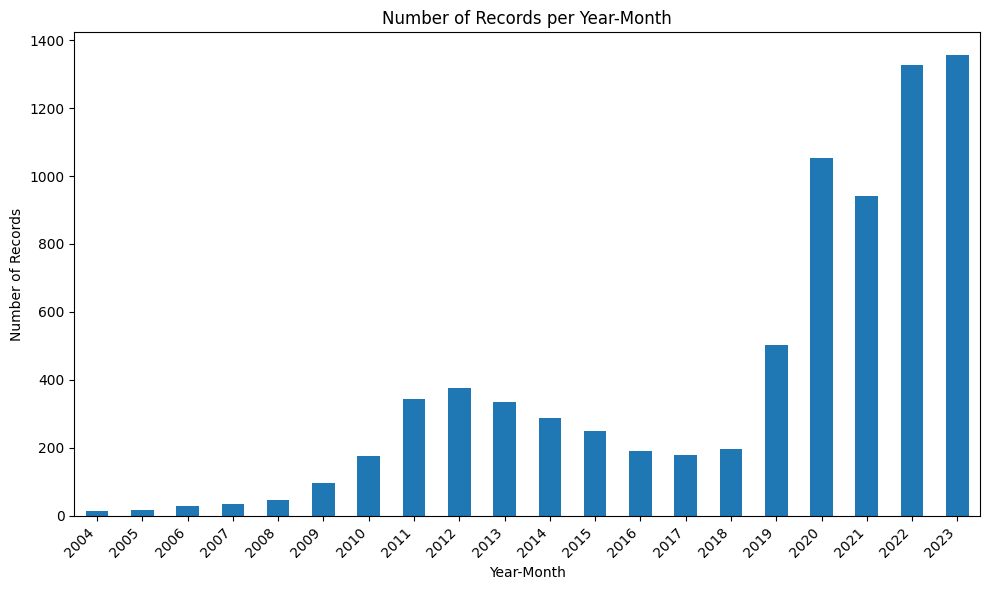

In [170]:
df["visit_date"] = pd.to_datetime(df["visit_date"])
df["visit_year"] = df["visit_date"].dt.year
df["visit_quarter"]=df["visit_date"].dt.quarter
df["visit_month"] = df["visit_date"].dt.month
df["visit_day_of_week"] = df["visit_date"].dt.dayofweek


# Group by 'year-month' and count the number of records
year_counts = df.groupby("visit_year").size()

# Plotting the counts
plt.figure(figsize=(10, 6))
year_counts.plot(kind="bar")
plt.title("Number of Records per Year-Month")
plt.xlabel("Year-Month")
plt.ylabel("Number of Records")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Handling Missing Values

In [171]:
# Ensure there is no negative data
numeric_df = df[
    ["prchs_qty", "prchs_amt", "consume_qty", "consume_amt"]
]
negative_values = (numeric_df < 0).any()
print(f"negative_values: \n{negative_values}")


negative_values: 
prchs_qty      False
prchs_amt      False
consume_qty    False
consume_amt    False
dtype: bool


In [172]:
# Fill all the N/As
print(
    f"Null features for raw_customer_visits: \n{pd.isnull(df).sum()}"
)
df = df.fillna(value=0)
print(f"Null features for customer_visits: \n{pd.isnull(df).sum()}")


Null features for raw_customer_visits: 
cust_id                 0
store_name              0
visit_date              0
prchs_qty            4060
prchs_amt            4060
consume_qty          2813
consume_amt          2813
visit_year              0
visit_quarter           0
visit_month             0
visit_day_of_week       0
dtype: int64
Null features for customer_visits: 
cust_id              0
store_name           0
visit_date           0
prchs_qty            0
prchs_amt            0
consume_qty          0
consume_amt          0
visit_year           0
visit_quarter        0
visit_month          0
visit_day_of_week    0
dtype: int64


## Add more features

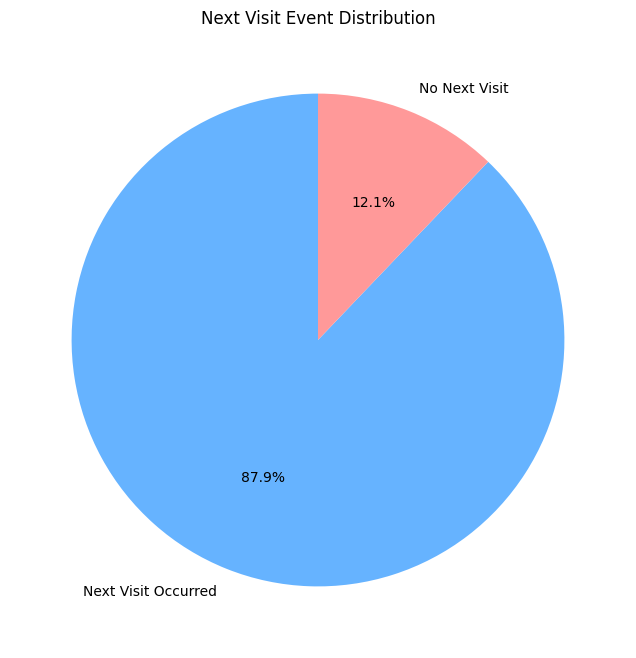

count    6815.000000
mean      128.575642
std       315.983012
min         0.000000
25%        14.000000
50%        34.000000
75%       101.000000
max      4414.000000
Name: days_to_next_visit, dtype: float64

In [173]:
df["cumulative_prchs_amt"] = df.groupby('cust_id')['prchs_amt'].cumsum()
df["cumulative_consume_amt"] = df.groupby('cust_id')['consume_amt'].cumsum()
df["days_since_last_visit"] = df.groupby("cust_id")["visit_date"].diff().dt.days
df["days_since_last_visit"] = df["days_since_last_visit"].fillna(value=0)
df["days_to_next_visit"] = df.groupby("cust_id")["visit_date"].diff(-1).dt.days.abs()

df["next_visit_event"] = df.groupby('cust_id')["visit_date"].shift(-1).notna().astype(int)

event_cnt = df["next_visit_event"].value_counts()

# Define labels and sizes for the pie chart
labels = ["Next Visit Occurred", "No Next Visit"]
sizes = [event_cnt[1], event_cnt[0]]
colors = ["#66b3ff", "#ff9999"]  # You can customize the colors

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct="%1.1f%%", startangle=90)
plt.title("Next Visit Event Distribution")
plt.show()

df["days_to_next_visit"].describe()

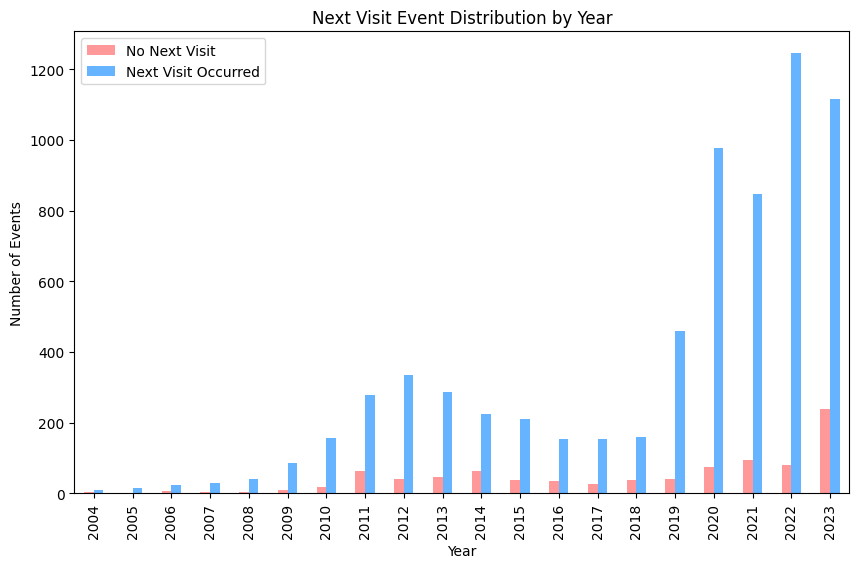

In [174]:
# Event Count on Yearly basis
# yearly_event_counts = df.groupby(["visit_year", "next_visit_event"]).size().unstack(fill_value=0)
yearly_event_counts = df.groupby(["visit_year", "next_visit_event"]).size().unstack(fill_value=0)
yearly_event_counts
# Plotting the bar chart
yearly_event_counts.plot(
    kind="bar", stacked=False, figsize=(10, 6), color=["#ff9999", "#66b3ff"]
)

plt.title("Next Visit Event Distribution by Year")
plt.xlabel("Year")
plt.ylabel("Number of Events")
plt.legend(labels=[ "No Next Visit","Next Visit Occurred"])
plt.show()

In [175]:
df[df["cust_id"] == "CUST00015"]


,cust_id,store_name,visit_date,prchs_qty,prchs_amt,consume_qty,consume_amt,visit_year,visit_quarter,visit_month,visit_day_of_week,cumulative_prchs_amt,cumulative_consume_amt,days_since_last_visit,days_to_next_visit,next_visit_event
176,CUST00015,River Road,2007-09-20,15.0,20700.0,0.0,0.0,2007,3,9,3,20700.0,0.0,0.0,18.0,1
177,CUST00015,River Road,2007-10-08,62.0,19995.0,0.0,0.0,2007,4,10,0,40695.0,0.0,18.0,52.0,1
178,CUST00015,River Road,2007-11-29,20.0,26660.0,0.0,0.0,2007,4,11,3,67355.0,0.0,52.0,NaN,0


## Price Sensitivity
There are three aspects of purchase and consume in this problem set
- for purchase:
    1. Per unit prchs
    2. Amount Purchased per visit
    3. cumulative purchased between visits
- for consume:
    1. Amount Consumed
    2. Interval Consumed between purchases
    3. Cumulative consumed between visits


The three aspects of price can be understood as the momentary, interval and long-term propensity to spend and to consume. The distance between spending and consuming can be expressed as cosine distance in three-dimensions.

Note that the difference between purchase and consume on second dimension is based on the assumption that the customer usually buys in bulk and consume by a portion of the training class per visit

In [176]:
# Per unit
df["per_unit_prchs"] = np.round(np.where(df["prchs_qty"]==0, 0, (df["prchs_amt"] / df["prchs_qty"])),2)


In [177]:




# Sample 5 random customers
unique_cust_id = df["cust_id"].unique()
random_cust_id_list = pd.Series(unique_cust_id).sample(n=20, random_state=32)
sample_df = df[df["cust_id"].isin(random_cust_id_list)]

def calculate_inerval_consume_amt(customer_df:pd.DataFrame):
    #Initialize cumulative sum
    cumulative_sum = 0

    #Iterate over each row in customer df
    for index, row in customer_df.iterrows():
        cumulative_sum += row["consume_amt"]
        customer_df.at[index, 'interval_consume_amt']=cumulative_sum
        if row["prchs_amt"]>0:
            cumulative_sum = 0
    return customer_df

sample_df = sample_df.groupby('cust_id').apply(calculate_inerval_consume_amt)
sample_df.reset_index(drop=True, inplace=True)
sample_df[["cust_id", "visit_date", "prchs_amt", "consume_amt", "interval_consume_amt", "cumulative_prchs_amt", "cumulative_consume_amt"]]

/var/folders/z9/v5sgb47s4kn55d7yx8yd5dyc0000gn/T/ipykernel_31761/3628747844.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_df = sample_df.groupby('cust_id').apply(calculate_inerval_consume_amt)


,cust_id,visit_date,prchs_amt,consume_amt,interval_consume_amt,cumulative_prchs_amt,cumulative_consume_amt
0,CUST00012,2006-09-19,12000.0,0.0,0.0,12000.0,0.0
1,CUST00012,2014-02-27,24687.0,0.0,0.0,36687.0,0.0
2,CUST00012,2017-09-21,999.0,0.0,0.0,37686.0,0.0
3,CUST00012,2019-09-19,0.0,1680.0,1680.0,37686.0,1680.0
4,CUST00012,2021-09-14,0.0,1680.0,3360.0,37686.0,3360.0
...,...,...,...,...,...,...,...
128,CUST00797,2022-06-12,0.0,0.0,9800.0,21000.0,11200.0
129,CUST00797,2022-07-30,0.0,2800.0,12600.0,21000.0,14000.0
130,CUST00797,2022-08-27,0.0,2800.0,15400.0,21000.0,16800.0
131,CUST00797,2023-03-13,0.0,4200.0,19600.0,21000.0,21000.0


In [178]:
def calculate_inerval_consume_amt(customer_df: pd.DataFrame):
    # Initialize cumulative sum
    cumulative_sum = 0

    # Iterate over each row in customer df
    for index, row in customer_df.iterrows():
        cumulative_sum += row["consume_amt"]
        customer_df.at[index, "interval_consume_amt"] = cumulative_sum
        if row["prchs_amt"] > 0:
            cumulative_sum = 0
    return customer_df

df = df.groupby("cust_id").apply(calculate_inerval_consume_amt)
df.reset_index(drop=True, inplace=True)
df[df["cust_id"] == "CUST00015"]

/var/folders/z9/v5sgb47s4kn55d7yx8yd5dyc0000gn/T/ipykernel_31761/3012458009.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("cust_id").apply(calculate_inerval_consume_amt)


,cust_id,store_name,visit_date,prchs_qty,prchs_amt,consume_qty,consume_amt,visit_year,visit_quarter,visit_month,visit_day_of_week,cumulative_prchs_amt,cumulative_consume_amt,days_since_last_visit,days_to_next_visit,next_visit_event,per_unit_prchs,interval_consume_amt
161,CUST00015,River Road,2007-09-20,15.0,20700.0,0.0,0.0,2007,3,9,3,20700.0,0.0,0.0,18.0,1,1380.0,0.0
162,CUST00015,River Road,2007-10-08,62.0,19995.0,0.0,0.0,2007,4,10,0,40695.0,0.0,18.0,52.0,1,322.5,0.0
163,CUST00015,River Road,2007-11-29,20.0,26660.0,0.0,0.0,2007,4,11,3,67355.0,0.0,52.0,NaN,0,1333.0,0.0


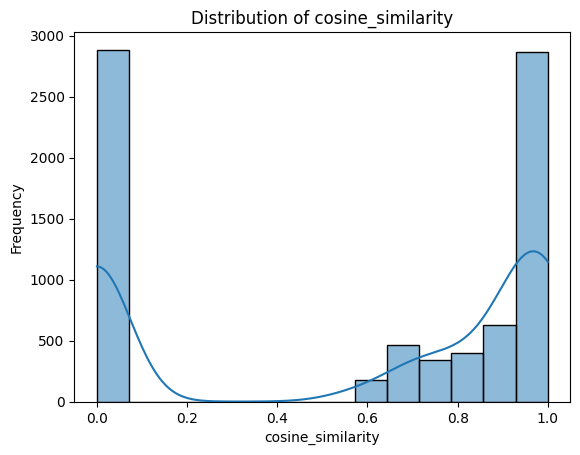

In [179]:
#Cosine Distance Between prchs & consume
# Extract the necessary columns and stack them into arrays
prchs_vector = df[["per_unit_prchs", "prchs_amt", "cumulative_prchs_amt"]].values
consume_vector = df[
    ["consume_amt", "interval_consume_amt", "cumulative_consume_amt"]
].values

# Normalize the vectors (cosine similarity involves the dot product of normalized vectors)
prchs_norm = np.linalg.norm(prchs_vector, axis=1, keepdims=True)
consume_norm = np.linalg.norm(consume_vector, axis=1, keepdims=True)

# Avoid division by zero by handling zero norms
valid_norms = (prchs_norm > 0) & (consume_norm > 0)

# Initialize cosine similarity array with zeros
cosine_similarities = np.zeros(len(df))

# Calculate cosine similarity where norms are non-zero
cosine_similarities[valid_norms.squeeze()] = (
    np.sum(
        prchs_vector[valid_norms.squeeze()] * consume_vector[valid_norms.squeeze()],
        axis=1,
    )
    / (prchs_norm[valid_norms] * consume_norm[valid_norms]).squeeze()
)

# Add the cosine similarity results to the DataFrame
df["cosine_similarity"] = cosine_similarities

# Display the resulting DataFrame

df[
    [
        "cust_id",
        "per_unit_prchs",
        "prchs_amt",
        "cumulative_prchs_amt",
        "interval_consume_amt",
        "cumulative_consume_amt",
        "cosine_similarity",
    ]
]

sns.histplot(
    df["cosine_similarity"], kde=True
)  # kde=True adds a Kernel Density Estimate curve
plt.title("Distribution of cosine_similarity")
plt.xlabel("cosine_similarity")
plt.ylabel("Frequency")
plt.show()

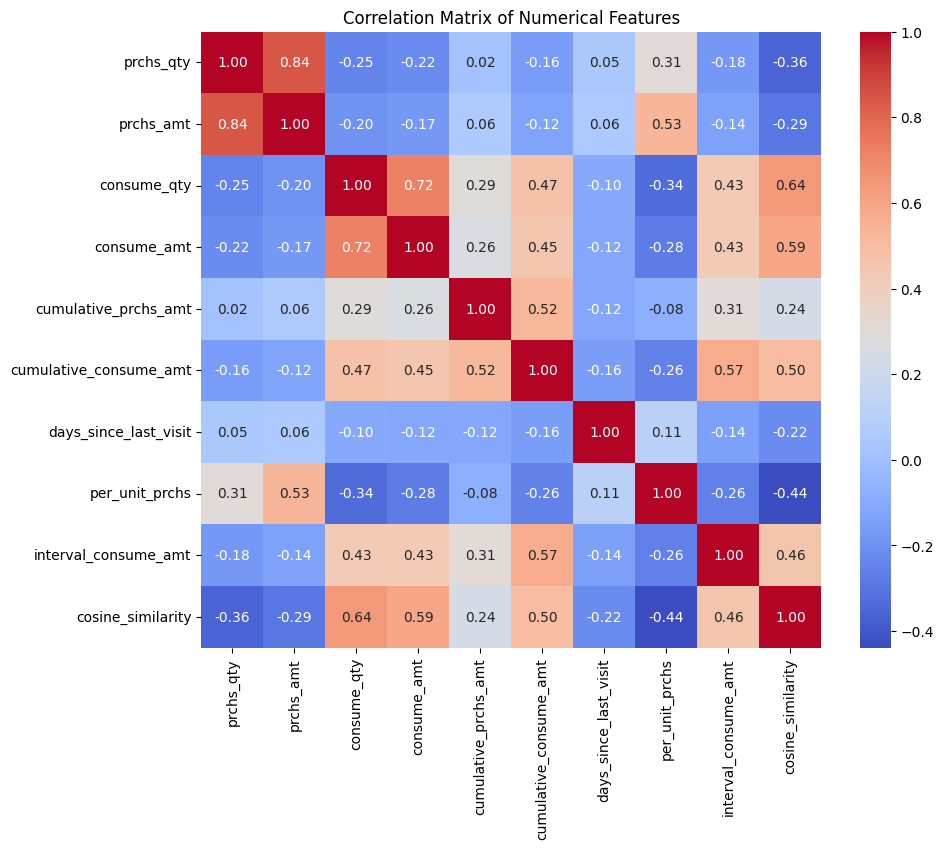

In [180]:
# Select the numerical features for correlation matrix
numerical_features = [
    "prchs_qty",
    "prchs_amt",
    "consume_qty",
    "consume_amt",
    "cumulative_prchs_amt",
    "cumulative_consume_amt",
    "days_since_last_visit",
    "per_unit_prchs",
    "interval_consume_amt",
    "cosine_similarity",
]

# Calculate the correlation matrix
corr_matrix = df[numerical_features].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Numerical Features")
plt.show()


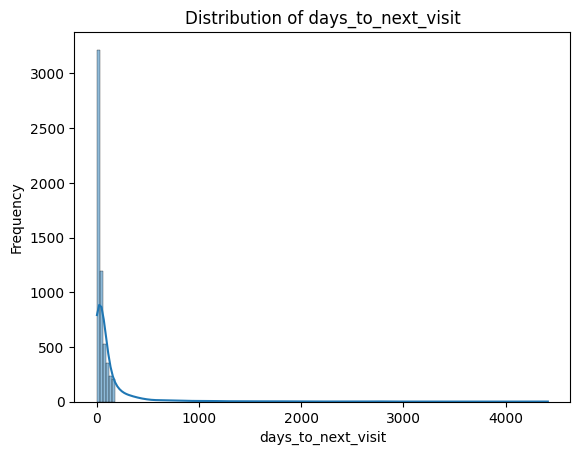

In [181]:
df["days_to_next_visit"].describe()

sns.histplot(
    df["days_to_next_visit"], kde=True, bins=range(0, 200, 30)
)  # kde=True adds a Kernel Density Estimate curve
plt.title("Distribution of days_to_next_visit")
plt.xlabel("days_to_next_visit")
plt.ylabel("Frequency")
plt.show()

In [182]:
#Train Test data split


training_date = "2023-01-01"
observation_date = "2024-01-01"
df_train = df[df["visit_date"] < training_date]
df_test = df[df["visit_date"] >= training_date]
# Corrected bins and labels
bins = [0,30, 60, 90, 120, 180, float("inf")]
labels = [
    "within 30 days",
    "within 30-60 days",
    "within 60-90 days",
    "within 90-120 days",
    "within 120-180 days",
    "lost",
]
# Fill the N/A based on the split
df_train["days_to_next_visit"].fillna(
    (pd.to_datetime(training_date) - df["visit_date"]).dt.days.abs(), inplace=True
)
df_train["next_visit_day_bin"] = pd.cut(
    df_train["days_to_next_visit"], bins=bins, labels=labels
)
df_test["days_to_next_visit"].fillna(
    (pd.to_datetime(observation_date) - df["visit_date"]).dt.days.abs(), inplace=True
)
df_test["next_visit_day_bin"] = pd.cut(
    df_test["days_to_next_visit"], bins=bins, labels=labels
)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

df_train
covariates = [
    "prchs_amt",
    "consume_amt",
    "cumulative_prchs_amt",
    "cumulative_consume_amt",
    "per_unit_prchs",
    "cosine_similarity",
    "days_since_last_visit",
    "next_visit_event",
    "interval_consume_amt",
]


label_encoder = LabelEncoder()
X_train = df_train[covariates]
y_train = df_train["next_visit_day_bin"]
y_train = label_encoder.fit_transform(y_train)
X_test = df_test[covariates]
y_test = df_test["next_visit_day_bin"]
y_test = label_encoder.fit_transform(y_test)

print(
    f"x_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}"
)
# Create an array of models
models = []
models.append(
    ("LR", LogisticRegression(multi_class="multinomial", solver="saga", max_iter=500))
)
models.append(("NB", GaussianNB()))
models.append(("RF", RandomForestClassifier()))
models.append(("SVC", SVC()))
models.append(("Dtree", DecisionTreeClassifier()))
models.append(("KNN", KNeighborsClassifier()))
models.append(("ADA", AdaBoostClassifier()))
models.append(("GD", GradientBoostingClassifier()))

for name, model in models:
    kfold = KFold(n_splits=2, shuffle=True, random_state=40)
    cv_result = cross_val_score(model, X_train, y_train, cv=kfold, scoring="accuracy")
    print(name, cv_result)

x_train: (6401, 9), y_train: (6401,), X_test: (1355, 9), y_test: (1355,)
LR [0.51827554 0.5378125 ]
NB [0.36925961 0.5040625 ]
RF [0.52327398 0.541875  ]
SVC [0.51858794 0.5303125 ]
Dtree [0.43611371 0.4290625 ]
KNN [0.4867229 0.50375  ]
ADA [0.43673852 0.184375  ]
GD [0.54014371 0.5578125 ]


In [183]:
#Voting Classification


voting_clf = VotingClassifier(estimators=models, voting='hard')
voting_clf.fit(X_train, y_train)
predictions = voting_clf.predict(X_test)
accuracy = accuracy_score(y_test, predictions)


print("Accuracy is: " + str(accuracy))

predictions

Accuracy is: 0.6339483394833948


array([0, 2, 2, ..., 0, 0, 0])

# Strategy on data handling

The time series data is imbalanced. Meaning that the time of which the visit occurs per customer is not normally distributed. This render the traditional time series analysis useless. However, there are other tools to handle this.


## Survival Analysis
It is a statistic strategy to analyse the expected duration of time until one or more events happen, such as death after drug trail etc... Survival Analysis is also widely applied to other fields such as customer retentions and so on.

## Time to Event Data
Time is measured until the event occurs. This period could the time since last visit

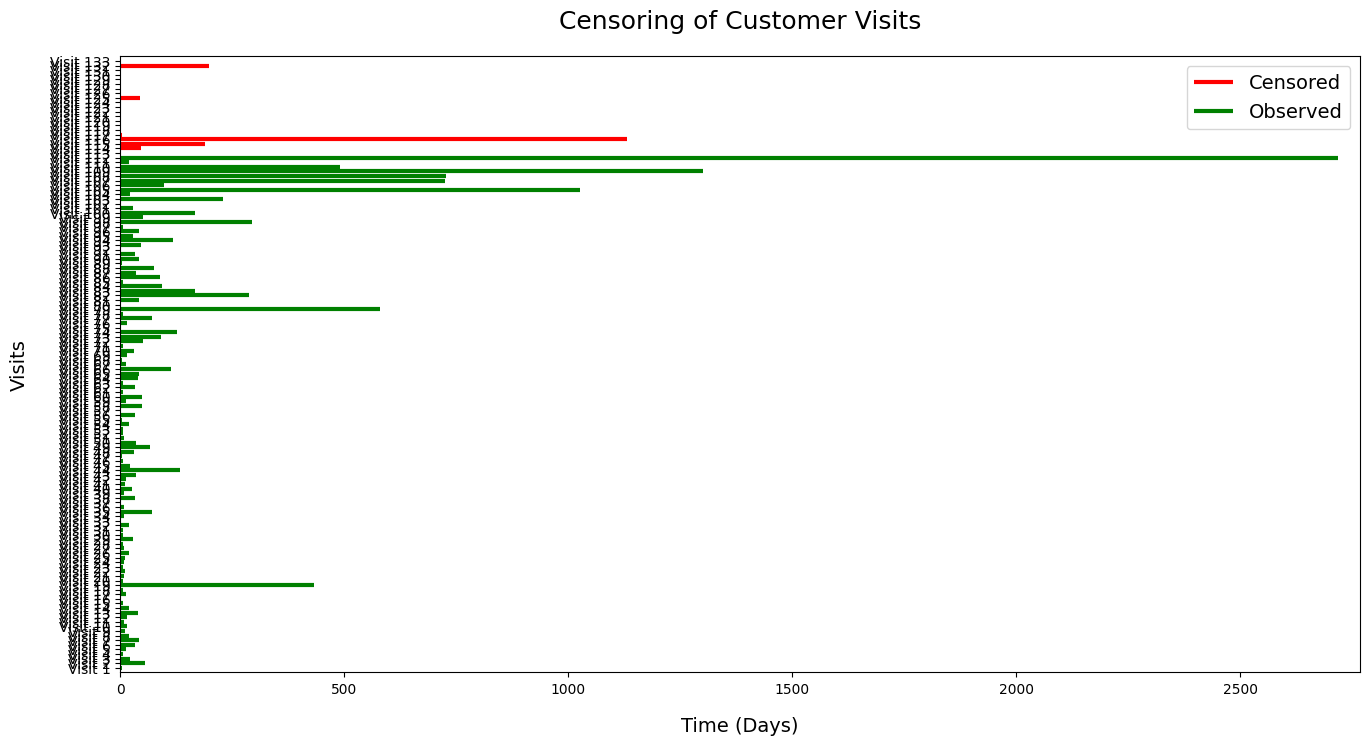

In [184]:
def draw_censoring_graph(df: pd.DataFrame, end_time: datetime = datetime.today()):
    # Ensure the DataFrame is sorted by 'next_visit_event' and 'days_to_next_visit' in descending order
    df_sorted = df.sort_values(by=["days_to_next_visit"], ascending=[True]).reset_index(
        drop=True
    )
    # Create y-values based on the sorted DataFrame
    y_values = np.arange(1, len(df_sorted) + 1)

    fig, ax = plt.subplots(figsize=(16, 8))

    # Plot censored visits (red) first so they appear at the top
    censored_mask = df_sorted["next_visit_event"] == 0
    ax.hlines(
        y=y_values[censored_mask],
        xmin=0,
        xmax=df_sorted.loc[censored_mask, "days_since_last_visit"],
        color="red",
        linewidth=3,
        label="Censored",
    )

    # Plot observed visits (green) so they appear below the censored visits
    observed_mask = df_sorted["next_visit_event"] == 1
    ax.hlines(
        y=y_values[observed_mask],
        xmin=0,
        xmax=df_sorted.loc[observed_mask, "days_since_last_visit"],
        color="green",
        linewidth=3,
        label="Observed",
    )

    # Styling the plot
    ax.set_xlabel("Time (Days)", size=14, labelpad=15)
    ax.set_ylabel("Visits", size=14, labelpad=15)
    ax.set_xlim(0, df_sorted["days_since_last_visit"].max() + 50)
    ax.set_ylim(0, len(df_sorted) + 1)
    ax.set_yticks(y_values)
    ax.set_yticklabels([f"Visit {i+1}" for i in range(len(df_sorted))])
    ax.legend(prop={"size": 14})
    ax.set_title("Censoring of Customer Visits", size=18, pad=20)

    plt.show()


sample_df = df[df["cust_id"].isin(random_cust_id_list)]
draw_censoring_graph(df=sample_df)


# KaplanMeierFitter
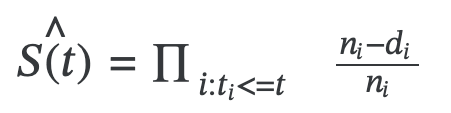

where  𝑛𝑖
  is a number of individuals who are at risk at time point  𝑡𝑖
  and  𝑑𝑖
  is a number of subjects that experienced the event at time  𝑡𝑖
 . [8]

          KM_estimate
timeline             
0.0          0.999063
1.0          0.990783
2.0          0.985627
3.0          0.978283
4.0          0.967346
...               ...
6589.0       0.081057
6737.0       0.081057
6758.0       0.081057
6809.0       0.081057
6866.0       0.081057

[1249 rows x 1 columns]


<Axes: xlabel='timeline'>

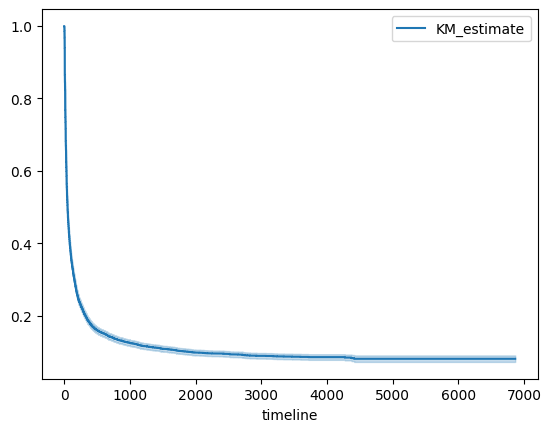

In [185]:
# Kaplan-Meier Estimate (Non-parametric Model)

T, E = df_train["days_to_next_visit"], df_train["next_visit_event"]
kmf = KaplanMeierFitter()
kmf.fit(durations=T, event_observed=E)
print(kmf.survival_function_)
kmf.plot_survival_function()


In [186]:
table = survival_table_from_events(T, E)
table

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,6,6,0,6401,6401
1.0,53,53,0,0,6395
2.0,34,33,1,0,6342
3.0,47,47,0,0,6308
4.0,70,70,0,0,6261
...,...,...,...,...,...
6589.0,1,0,1,0,5
6737.0,1,0,1,0,4
6758.0,1,0,1,0,3


<Axes: xlabel='timeline'>

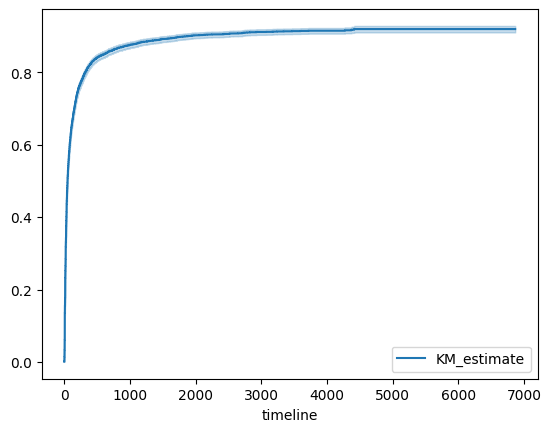

In [187]:
kmf.plot_cumulative_density()

In [188]:
print(f'median survival time:{kmf.median_survival_time_}')


median survival time:49.0


In [189]:
predicted_visit_probability = kmf.predict(df_test["days_to_next_visit"])
predicted_visit_probability = predicted_visit_probability.reset_index(drop=True)
df_test["predicted_visit_probability"] = predicted_visit_probability
result_df = df_test[
    ["days_to_next_visit", "next_visit_event", "predicted_visit_probability"]
]
result_df

,days_to_next_visit,next_visit_event,predicted_visit_probability
0,74.0,0,0.421451
1,16.0,1,0.748554
2,41.0,1,0.543147
3,55.0,1,0.477545
4,16.0,1,0.748554
...,...,...,...
1350,24.0,0,0.668175
1351,21.0,0,0.690227
1352,12.0,0,0.823427
1353,9.0,0,0.854372


In [190]:
# Define the threshold range from 0.5 to 1 with a step of 0.05
thresholds_to_check = np.arange(0.5, 1.05, 0.05)

# Initialize lists to store FPR and TPR for the specified thresholds
fpr_list = []
tpr_list = []

# Compute ROC curve data
fpr, tpr, all_thresholds = roc_curve(
    result_df["next_visit_event"], result_df["predicted_visit_probability"]
)

# Iterate through the specified thresholds and find the corresponding FPR and TPR
for threshold in thresholds_to_check:
    # Find the closest threshold in the computed ROC curve data
    closest_index = np.argmin(np.abs(all_thresholds - threshold))
    fpr_list.append(fpr[closest_index])
    tpr_list.append(tpr[closest_index])

# Create a ROC table with the specified thresholds
roc_table_custom = pd.DataFrame(
    {
        "Threshold": thresholds_to_check,
        "False Positive Rate": fpr_list,
        "True Positive Rate": tpr_list,
    }
)

# Display the ROC table
print(roc_table_custom)


    Threshold  False Positive Rate  True Positive Rate
0        0.50             0.416667            0.827803
1        0.55             0.366667            0.769507
2        0.60             0.337500            0.709417
3        0.65             0.312500            0.642152
4        0.70             0.233333            0.569507
5        0.75             0.191667            0.482511
6        0.80             0.137500            0.347085
7        0.85             0.095833            0.269955
8        0.90             0.075000            0.226906
9        0.95             0.066667            0.088789
10       1.00             0.000000            0.000897


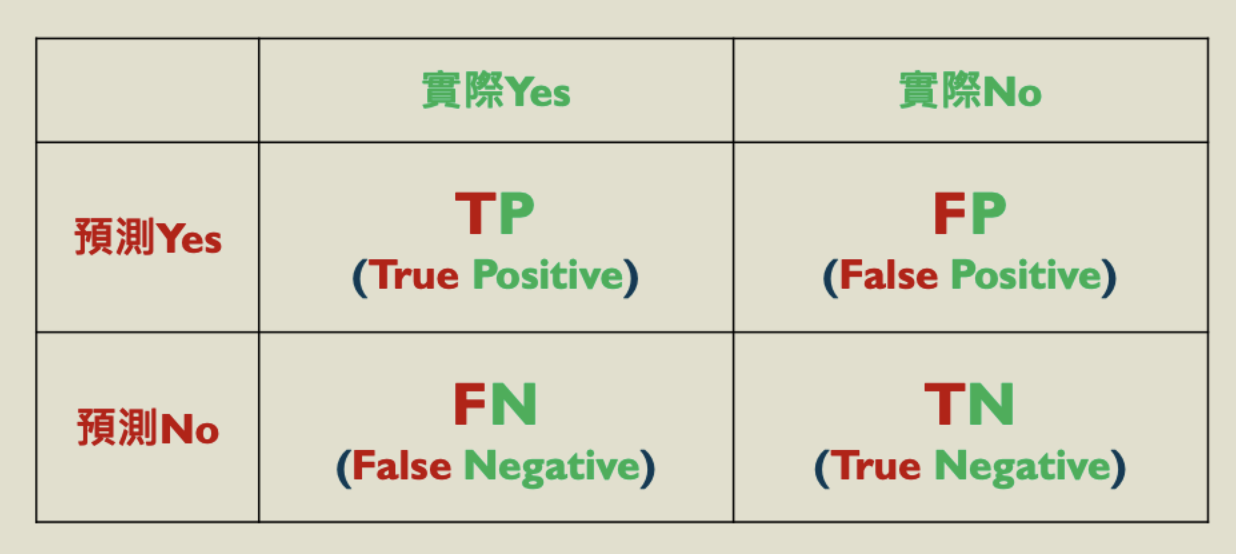

- False Positive Rate = [1- specificity]
  - specificity = TN/(TN+FP)
- True Positive Rate = [Sensitivity]
  - sensitivity = TP/(TP+FN)

# Cox Proportional Hazard Model
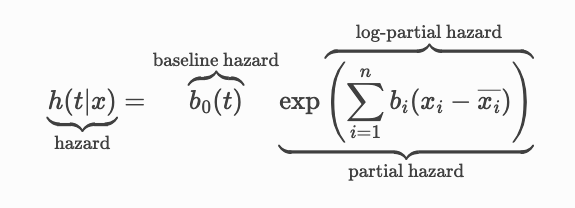

- The only time component is in the baseline hazard, 
$$
b_0(t)
$$



In [191]:
# Cox Proportional Hazards Model
covariates = [
    "prchs_amt",
    "consume_amt",
    "cumulative_prchs_amt",
    "cumulative_consume_amt",
    "per_unit_prchs",
    "cosine_similarity",
    "days_since_last_visit",
    "days_to_next_visit",
    "next_visit_event",
]

cph = CoxPHFitter()
cph.fit(df_train[covariates], duration_col="days_to_next_visit", event_col='next_visit_event')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 6401 total observations, 701 right-censored observations>
             duration col = 'days_to_next_visit'
                event col = 'next_visit_event'
      baseline estimation = breslow
   number of observations = 6401
number of events observed = 5700
   partial log-likelihood = -44441.19
         time fit was run = 2024-08-21 12:37:35 UTC

---
                        coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                               
prchs_amt               0.00      1.00      0.00            0.00            0.00                1.00                1.00
consume_amt            -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
cumulative_prchs_amt    0.00      1.00      0.00            0.00            0.00                1.00                1.00
cumulative_consume_amt  0.00      1.00      0.00            0.00            0.00                1.00                1.00
per_unit_prchs         -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
cosine_similarity       0.88      2.40      0.04            0.80            0.96                2.21                2.61
days_since_last_visit  -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00

                        cmp to     z      p  -log2(p)
covariate                                            
prchs_amt                 0.00 10.90 <0.005     89.54
consume_amt               0.00 -2.20   0.03      5.17
cumulative_prchs_amt      0.00 16.70 <0.005    205.55
cumulative_consume_amt    0.00 14.36 <0.005    152.92
per_unit_prchs            0.00 -9.86 <0.005     73.71
cosine_similarity         0.00 21.14 <0.005    327.21
days_since_last_visit     0.00 -4.01 <0.005     13.98
---
Concordance = 0.71
Partial AIC = 88896.38
log-likelihood ratio test = 2354.20 on 7 df
-log2(p) of ll-ratio test = inf

In [192]:
predicted_median_survival_times = cph.predict_median(df_test[covariates])
c_index_test = concordance_index(df_test["days_to_next_visit"], predicted_median_survival_times, df_test["next_visit_event"])
print(f"Test Set Concordance Index: {c_index_test}")

Test Set Concordance Index: 0.653264130042443


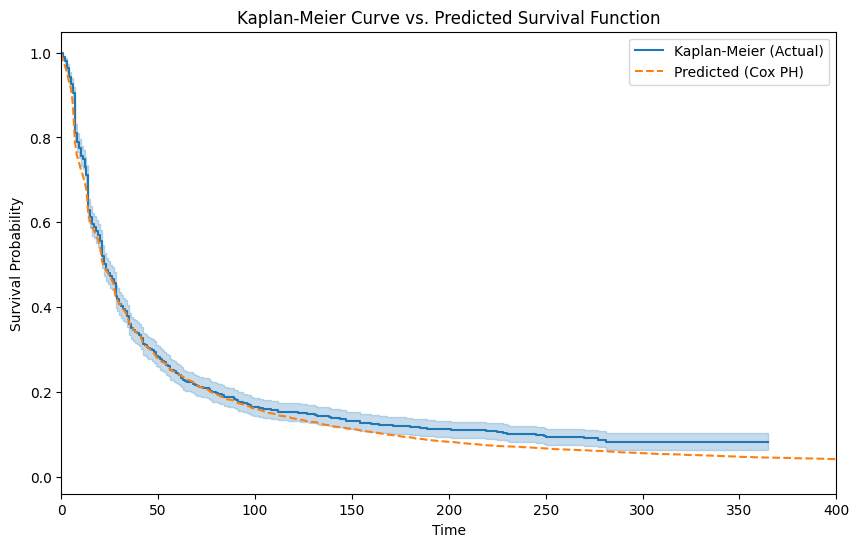

In [193]:
# Step 1: Fit the Kaplan-Meier estimator on the actual data
kmf = KaplanMeierFitter()
kmf.fit(df_test["days_to_next_visit"], event_observed=df_test["next_visit_event"])

# Step 2: Compute the average predicted survival function from the Cox model
predicted_survival_function = cph.predict_survival_function(X_test).mean(axis=1)

# Step 3: Plot both the Kaplan-Meier curve and the predicted survival curve
plt.figure(figsize=(10, 6))

# Plot the Kaplan-Meier curve
kmf.plot_survival_function(label="Kaplan-Meier (Actual)", ci_show=True)

# Plot the predicted survival curve from Cox model
plt.plot(
    predicted_survival_function.index,
    predicted_survival_function,
    label="Predicted (Cox PH)",
    linestyle="--",
)

# Limit the x-axis (time) to 1000
plt.xlim(0, 400)
# Adding titles and labels
plt.title("Kaplan-Meier Curve vs. Predicted Survival Function")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.legend()

# Show the plot
plt.show()


<Axes: xlabel='log(HR) (95% CI)'>

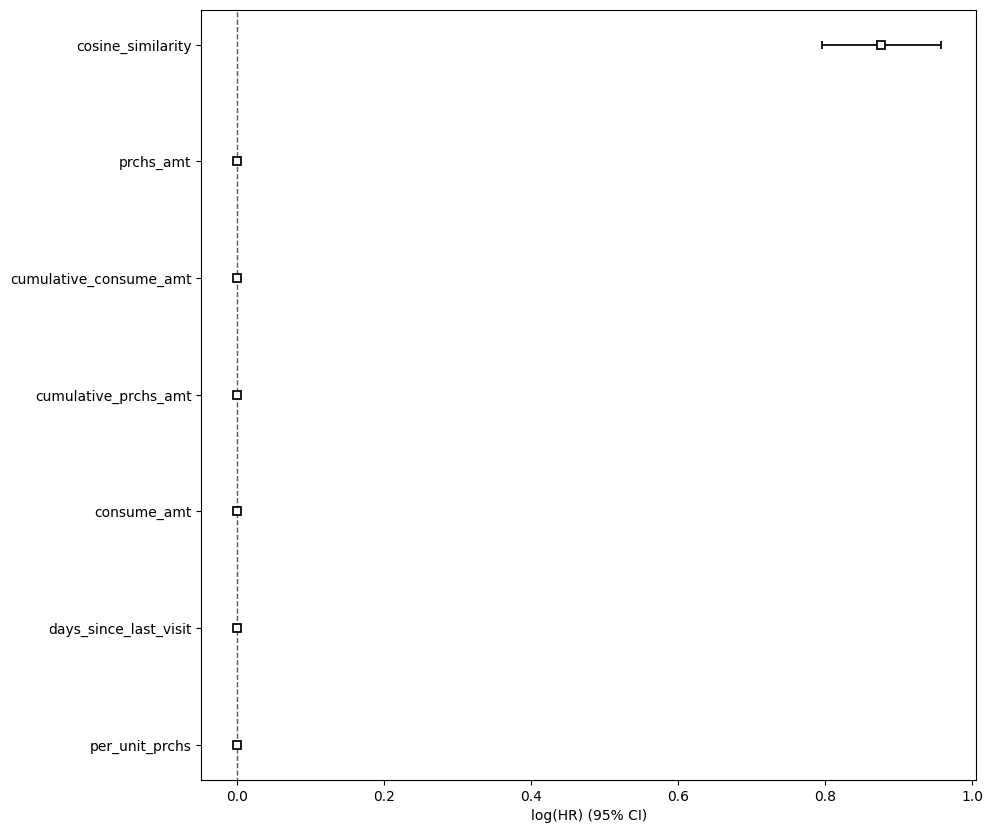

In [194]:
plt.subplots(figsize=(10,10))
cph.plot()

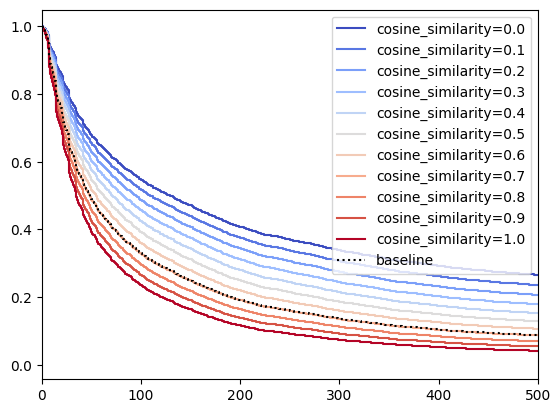

In [195]:
cph.plot_partial_effects_on_outcome(
    covariates="cosine_similarity",
    values=[round(x * 0.1, 1) for x in range(11)],
    cmap="coolwarm",
)
plt.xlim(0,500)
plt.show()


In [196]:
cph.check_assumptions(df_train[covariates], p_value_threshold= 0.05)

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 6401 total observations, 701 right-censored observations>
         test_name = proportional_hazard_test

---
                             test_statistic      p  -log2(p)
consume_amt            km              7.22   0.01      7.12
                       rank            8.00 <0.005      7.74
cosine_similarity      km             77.33 <0.005     59.27
                       rank           76.02 <0.005     58.31
cumulative_consume_amt km              4.72   0.03      5.07
                       rank            3.31   0.07      3.86
cumulative_prchs_amt   km              9.47 <0.005      8.90
                       rank            7.87   0.01      7.64
days_since_last_visit  km             41.58 <0.005     33.04
                       rank           39.84 <0.005     31.75
per_unit_prchs         km              3.66   0.06      4.17
                       rank            3.95   0.05      4.42
prchs_amt              km              9.94 <0.005      9.27
                       rank           10.05 <0.005      9.36



1. Variable 'prchs_amt' failed the non-proportional test: p-value is 0.0015.

   Advice 1: the functional form of the variable 'prchs_amt' might be incorrect. That is, there may
be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'prchs_amt' using pd.cut, and then specify it in
`strata=['prchs_amt', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


2. Variable 'consume_amt' failed the non-proportional test: p-value is 0.0047.

   Advice 1: the functional form of the variable 'consume_amt' might be incorrect. That is, there
may be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a 

[]

In [197]:
result = proportional_hazard_test(cph, df_train[covariates], time_transform='rank')
result.print_summary(decimals=3, model='untransformed variables')

<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 6401 total observations, 701 right-censored observations>
         test_name = proportional_hazard_test

---
                        test_statistic      p  -log2(p)
consume_amt                       8.00 <0.005      7.74
cosine_similarity                76.02 <0.005     58.31
cumulative_consume_amt            3.31   0.07      3.86
cumulative_prchs_amt              7.87   0.01      7.64
days_since_last_visit            39.84 <0.005     31.75
per_unit_prchs                    3.95   0.05      4.42
prchs_amt                        10.05 <0.005      9.36

In [198]:
from lifelines import WeibullAFTFitter, ExponentialFitter, LogNormalFitter, LogLogisticFitter

wb = WeibullAFTFitter()
ex = ExponentialFitter()
log = LogNormalFitter()
loglogis = LogLogisticFitter()


df_train[covariates].sort_values(by=["days_to_next_visit"], ascending=[True])
# # WeiBull
wb_df = df_train[covariates]
wb_df["days_to_next_visit"] = wb_df["days_to_next_visit"] + 0.000000001
wb.fit(
    wb_df,
    duration_col="days_to_next_visit",
    event_col="next_visit_event",
)
wb.print_summary(3)


<lifelines.WeibullAFTFitter: fitted with 6401 total observations, 701 right-censored observations>
             duration col = 'days_to_next_visit'
                event col = 'next_visit_event'
   number of observations = 6401
number of events observed = 5700
           log-likelihood = -34084.422
         time fit was run = 2024-08-21 12:37:37 UTC

---
                                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param   covariate                                                                                                                
lambda_ consume_amt             0.000     1.000     0.000          -0.000           0.000               1.000               1.000
        cosine_similarity      -2.014     0.133     0.065          -2.141          -1.887               0.118               0.152
        cumulative_consume_amt -0.000     1.000     0.000          -0.000          -0.000               1.000               1.000
        cumulative_prchs_amt   -0.000     1.000     0.000          -0.000          -0.000               1.000               1.000
        days_since_last_visit   0.000     1.000     0.000           0.000           0.000               1.000               1.000
        per_unit_prchs          0.000     1.000     0.000           0.000           0.000               1.000               1.000
        prchs_amt              -0.000     1.000     0.000          -0.000          -0.000               1.000               1.000
        Intercept               6.314   552.463     0.048           6.221           6.408             502.955             606.844
rho_    Intercept              -0.493     0.611     0.010          -0.512          -0.473               0.599               0.623

                                cmp to       z       p  -log2(p)
param   covariate                                               
lambda_ consume_amt              0.000   0.590   0.555     0.849
        cosine_similarity        0.000 -31.066 <0.0005   701.463
        cumulative_consume_amt   0.000  -8.139 <0.0005    51.159
        cumulative_prchs_amt     0.000 -19.711 <0.0005   284.880
        days_since_last_visit    0.000   2.723   0.006     7.272
        per_unit_prchs           0.000  10.509 <0.0005    83.395
        prchs_amt                0.000 -14.603 <0.0005   158.019
        Intercept                0.000 131.820 <0.0005       inf
rho_    Intercept                0.000 -49.054 <0.0005       inf
---
Concordance = 0.706
AIC = 68186.843
log-likelihood ratio test = 2928.558 on 7 df
-log2(p) of ll-ratio test = inf

In [199]:
print(f"WeiBullAFT median: {wb.median_survival_time_}")
print(f"WeiBullAFT mean: {wb.mean_survival_time_}")


WeiBullAFT median: 72.46531756431946
WeiBullAFT mean: 194.12435776159168


<Axes: xlabel='log(accelerated failure rate) (95% CI)'>

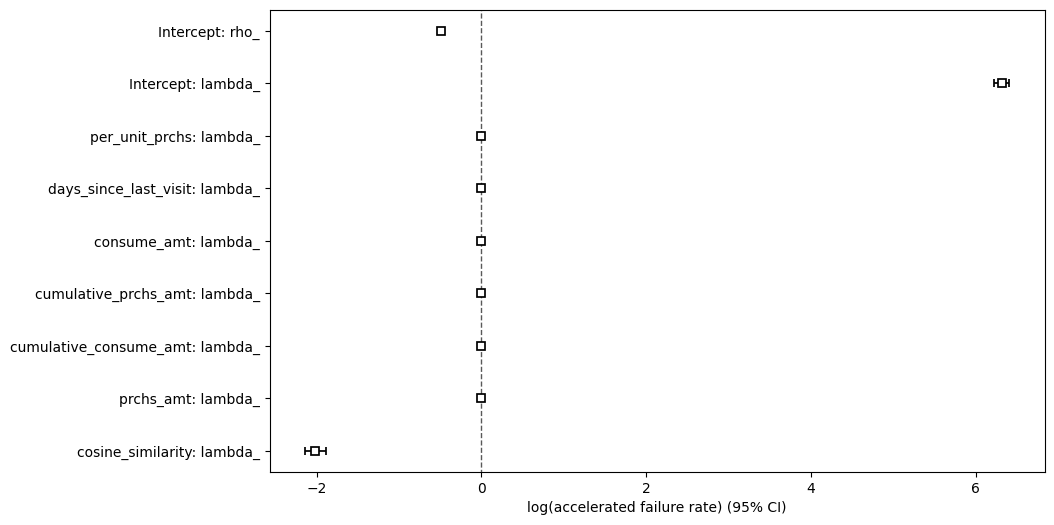

In [200]:


plt.subplots(figsize=(10,6))
wb.plot()